## Exercises

We will calculate evapotranspiration using two methods: Thornthwaite and Penman. After that, we will compare these estimates with measurements of pan evaporation.

## Download data from the IMS

Please follow the instructions below **exactly as they are written**.
Go to the [Israel Meteorological Service website](https://ims.gov.il/en/data_gov), and download the following data:

1. 10-min data
 * On the navigation bar on the left, choose "10 Minutes Observations" 
 * Clock: Local time winter (UTC +2)
 * Choose the following date range: 01/01/2020 00:00 to 01/01/2021 00:00
 * Choose station Bet Dagan
 * Select units: Celcius, m/s, KJ/m$^2$
 * Under "Select parameters", choose "Check All"
 * Choose option "by station", then "Submit"
 * "Download Result as" CSV, call it `bet-dagan-10min.csv`
2. radiation data
 * On the navigation bar on the left, choose "Hourly Radiation"
 * Clock: Local time winter (UTC +2)
 * Choose the following date range: 01/01/2020 00:00 to 01/01/2021 00:00
 * Select hours: Check all hours
 * Choose station Bet Dagan
 * Select units: KJ/m$^2$
 * Under "Select parameters", choose "Check All"
 * "Download Result as" CSV, call it `bet-dagan-radiation.csv`
3. pan evaporation data
 * On the navigation bar on the left, choose "Daily Observations"
 * Choose the following date range: 01/01/2020 00:00 to 01/01/2021 00:00
 * Choose station Bet Dagan Man
 * Select units: Celcius
 * Under "Select parameters", choose "Check All"
 * "Download Result as" CSV, call it `bet-dagan-pan.csv`

If for some reason you can't download the files following the instructions above, click here:

* <a href="bet-dagan-10min.csv" download>bet-dagan-10min.csv</a>
* <a href="bet-dagan-radiation.csv" download>bet-dagan-radiation.csv</a>
* <a href="bet-dagan-pan.csv" download>bet-dagan-pan.csv</a>
 
## Install and import relevant packages 

We will need to use two new packages:

* [pyet: Estimation of Potential Evapotranspiration](https://github.com/pyet-org/pyet)
* [noaa_ftp: Download data from NOAA](https://github.com/javad-rzvn/noaa_ftp)

If you don't have them installed yet, run this:

```python
!pip install pyet
!pip install noaa_ftp
```


Once they are installed, import all the necessary packages for today's exercises.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # datetime converter for a matplotlib
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
import pyet
from noaa_ftp import NOAA

## import 10-minute data

In [2]:
df = pd.read_csv('bet-dagan-10min.csv',
                #  encoding = "ISO-8859-8",  # this shows hebrew characters properly
                 na_values=["-"]           # substitute "-" for NaN
                 )
df['timestamp'] = pd.to_datetime(df['Date & Time (Winter)'], dayfirst=True)
df = df.set_index('timestamp')
# choose only relevant columns to us
# if we don't do this the taking the mean will fail because not all columns are numeric. try df.dtypes to see why
df = df[["Temperature (°C)",
         "Wind speed (m/s)",
         "Pressure at station level (hPa)",
         "Relative humidity (%)"]]
# resample to daily data according to "mean"
df = df.resample('D').mean()
# convert hecto pascals (hPa) to kilo pascals (kPa)
df["Pressure (kPa)"] = df["Pressure at station level (hPa)"] / 10.0
df

,Temperature (°C),Wind speed (m/s),Pressure at station level (hPa),Relative humidity (%),Pressure (kPa)
timestamp,,,,,
2020-01-01,12.375000,1.552083,1013.263889,80.590278,101.326389
2020-01-02,12.020833,2.207639,1011.922917,85.631944,101.192292
2020-01-03,12.962500,4.763194,1013.757639,60.756944,101.375764
2020-01-04,10.849306,5.439583,1011.581250,76.909722,101.158125
2020-01-05,12.956250,4.765278,1012.361806,79.583333,101.236181
...,...,...,...,...,...
2020-12-28,14.797917,2.631915,1014.429861,58.729167,101.442986
2020-12-29,14.146528,1.493750,1015.031944,71.215278,101.503194
2020-12-30,14.186806,1.776389,1013.234028,68.923611,101.323403


## import radiation data

In [3]:
df_rad = pd.read_csv('bet-dagan-radiation.csv',
                     na_values=["-"]
                     )
df_rad['Date'] = pd.to_datetime(df_rad['Date'], dayfirst=True)
df_rad = df_rad.set_index('Date')
df_rad


,Station,Radiation type,Hourly radiation 05-06 (KJ/m^2),Hourly radiation 06-07 (KJ/m^2),Hourly radiation 07-08 (KJ/m^2),Hourly radiation 08-09 (KJ/m^2),Hourly radiation 09-10 (KJ/m^2),Hourly radiation 10-11 (KJ/m^2),Hourly radiation 11-12 (KJ/m^2),Hourly radiation 12-13 (KJ/m^2),Hourly radiation 13-14 (KJ/m^2),Hourly radiation 14-15 (KJ/m^2),Hourly radiation 15-16 (KJ/m^2),Hourly radiation 16-17 (KJ/m^2),Hourly radiation 17-18 (KJ/m^2),Hourly radiation 18-19 (KJ/m^2)
Date,,,,,,,,,,,,,,,,
2020-01-01,Bet Dagan Rad 01/1991-04/2024,Global,0.0,10.8,270.0,594.0,1252.8,1407.6,1800.0,1587.6,1443.6,1123.2,482.4,57.6,0.0,0.0
2020-01-01,Bet Dagan Rad 01/1991-04/2024,Direct,0.0,3.6,72.0,428.4,1393.2,1281.6,1911.6,1414.8,1112.4,1083.6,752.4,0.0,0.0,0.0
2020-01-01,Bet Dagan Rad 01/1991-04/2024,Diffused,0.0,10.8,216.0,403.2,543.6,586.8,590.4,684.0,770.4,637.2,252.0,57.6,0.0,0.0
2020-01-02,Bet Dagan Rad 01/1991-04/2024,Global,0.0,10.8,241.2,518.4,1018.8,93.6,129.6,345.6,720.0,673.2,478.8,82.8,0.0,0.0
2020-01-02,Bet Dagan Rad 01/1991-04/2024,Direct,0.0,3.6,57.6,100.8,471.6,0.0,0.0,32.4,140.4,334.8,680.4,79.2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,Bet Dagan Rad 01/1991-04/2024,Direct,0.0,0.0,892.8,1998.0,2455.2,2696.4,2710.8,2545.2,2386.8,2066.4,1328.4,169.2,0.0,0.0
2020-12-31,Bet Dagan Rad 01/1991-04/2024,Diffused,0.0,14.4,158.4,270.0,320.4,360.0,388.8,403.2,378.0,316.8,219.6,54.0,0.0,0.0
2021-01-01,Bet Dagan Rad 01/1991-04/2024,Global,0.0,14.4,302.4,882.0,1432.8,1814.4,1962.0,1897.2,1602.0,1170.0,572.4,75.6,0.0,0.0


Choose only "Global" radiation. Then sum all hours of the day, and convert from kJ to MJ.

In [4]:
df_rad = df_rad[df_rad["Radiation type"] == "Global "]
df_rad['daily_radiation_MJ_per_m2_per_day'] = (df_rad.iloc[:, 2:]    # take all rows, columns 2 to end
                                                           .sum(axis=1) /  # sum all columns
                                                           1000            # divide by 1000 to convert from kJ to MJ
                                                    )
df_rad

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_93264/3322402408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rad['daily_radiation_MJ_per_m2_per_day'] = (df_rad.iloc[:, 2:]    # take all rows, columns 2 to end


,Station,Radiation type,Hourly radiation 05-06 (KJ/m^2),Hourly radiation 06-07 (KJ/m^2),Hourly radiation 07-08 (KJ/m^2),Hourly radiation 08-09 (KJ/m^2),Hourly radiation 09-10 (KJ/m^2),Hourly radiation 10-11 (KJ/m^2),Hourly radiation 11-12 (KJ/m^2),Hourly radiation 12-13 (KJ/m^2),Hourly radiation 13-14 (KJ/m^2),Hourly radiation 14-15 (KJ/m^2),Hourly radiation 15-16 (KJ/m^2),Hourly radiation 16-17 (KJ/m^2),Hourly radiation 17-18 (KJ/m^2),Hourly radiation 18-19 (KJ/m^2),daily_radiation_MJ_per_m2_per_day
Date,,,,,,,,,,,,,,,,,
2020-01-01,Bet Dagan Rad 01/1991-04/2024,Global,0.0,10.8,270.0,594.0,1252.8,1407.6,1800.0,1587.6,1443.6,1123.2,482.4,57.6,0.0,0.0,10.0296
2020-01-02,Bet Dagan Rad 01/1991-04/2024,Global,0.0,10.8,241.2,518.4,1018.8,93.6,129.6,345.6,720.0,673.2,478.8,82.8,0.0,0.0,4.3128
2020-01-03,Bet Dagan Rad 01/1991-04/2024,Global,0.0,10.8,334.8,1040.4,1612.8,1846.8,1904.4,1947.6,1296.0,964.8,669.6,46.8,0.0,0.0,11.6748
2020-01-04,Bet Dagan Rad 01/1991-04/2024,Global,0.0,3.6,97.2,237.6,208.8,208.8,93.6,79.2,352.8,144.0,183.6,36.0,0.0,0.0,1.6452
2020-01-05,Bet Dagan Rad 01/1991-04/2024,Global,0.0,7.2,118.8,226.8,421.2,882.0,1296.0,1090.8,1242.0,1101.6,388.8,79.2,0.0,0.0,6.8544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,Bet Dagan Rad 01/1991-04/2024,Global,0.0,14.4,349.2,1000.8,1551.6,1810.8,2048.4,1796.4,1627.2,993.6,482.4,68.4,0.0,0.0,11.7432
2020-12-29,Bet Dagan Rad 01/1991-04/2024,Global,0.0,14.4,342.0,936.0,1530.0,1926.0,2088.0,1994.4,1702.8,1216.8,604.8,64.8,0.0,0.0,12.4200
2020-12-30,Bet Dagan Rad 01/1991-04/2024,Global,0.0,21.6,302.4,986.4,1526.4,1922.4,2080.8,2019.6,1720.8,1238.4,612.0,68.4,0.0,0.0,12.4992


Now we can add the daily radiation we have just calculated to the first dataframe containing temperature, RH, etc.

In [5]:
df['daily_radiation_MJ_per_m2_per_day'] =  df_rad['daily_radiation_MJ_per_m2_per_day']
df

,Temperature (°C),Wind speed (m/s),Pressure at station level (hPa),Relative humidity (%),Pressure (kPa),daily_radiation_MJ_per_m2_per_day
timestamp,,,,,,
2020-01-01,12.375000,1.552083,1013.263889,80.590278,101.326389,10.0296
2020-01-02,12.020833,2.207639,1011.922917,85.631944,101.192292,4.3128
2020-01-03,12.962500,4.763194,1013.757639,60.756944,101.375764,11.6748
2020-01-04,10.849306,5.439583,1011.581250,76.909722,101.158125,1.6452
2020-01-05,12.956250,4.765278,1012.361806,79.583333,101.236181,6.8544
...,...,...,...,...,...,...
2020-12-28,14.797917,2.631915,1014.429861,58.729167,101.442986,11.7432
2020-12-29,14.146528,1.493750,1015.031944,71.215278,101.503194,12.4200
2020-12-30,14.186806,1.776389,1013.234028,68.923611,101.323403,12.4992


## import pan evaporation data

In [6]:
df_pan = pd.read_csv('bet-dagan-pan.csv',
                     na_values=["-"]           # substitute "-" for NaN
                    )
df_pan['Date'] = pd.to_datetime(df_pan['Date'], dayfirst=True)
df_pan = df_pan.set_index('Date')
df_pan

,Station,Maximum Temperature (°C),Minimum Temperature (°C),Grass Temperature (°C),Hail,Frost,Snow,Fog,Thunder,Lightening,Sand storm,Gale,Accumulated 6 hr evaporation (mm),Accumulated 12 hr evaporation (mm),Daily evaporation type A (mm),Daily evaporation type A code (code),Sunshine duration (minutes)
Date,,,,,,,,,,,,,,,,,
2020-01-01,Bet Dagan Man 01/1964-04/2024,NaN,NaN,NaN,0,NaN,0,0,0,0,0,NaN,NaN,NaN,0.8,0.0,NaN
2020-01-02,Bet Dagan Man 01/1964-04/2024,NaN,NaN,NaN,0,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,Bet Dagan Man 01/1964-04/2024,NaN,NaN,NaN,0,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,Bet Dagan Man 01/1964-04/2024,NaN,NaN,NaN,0,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,Bet Dagan Man 01/1964-04/2024,NaN,NaN,NaN,0,NaN,0,0,1,0,0,NaN,NaN,NaN,2.4,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,Bet Dagan Man 01/1964-04/2024,NaN,NaN,NaN,0,NaN,0,0,0,0,0,NaN,NaN,NaN,3.0,0.0,NaN
2020-12-29,Bet Dagan Man 01/1964-04/2024,NaN,NaN,NaN,0,NaN,0,0,0,0,0,NaN,NaN,NaN,1.8,0.0,NaN
2020-12-30,Bet Dagan Man 01/1964-04/2024,NaN,NaN,NaN,0,NaN,0,0,0,0,0,NaN,NaN,NaN,2.4,0.0,NaN


## calculate penman

We need some data about the Bet Dagan Station. [See here](https://ims.gov.il/en/node/184).

* Latitude: 32.0073°
* Elevation: 31 m


In [7]:
# the site elevation [m]
elevation = 31.0
# the site latitude [rad]
latitude = pyet.utils.deg_to_rad(32.0073)
penm = pyet.combination.penman(tmean=df["Temperature (°C)"],
                               wind=df["Wind speed (m/s)"],
                               pressure=df["Pressure (kPa)"],
                               elevation=elevation,
                               rh=df["Relative humidity (%)"],
                               rs=df["daily_radiation_MJ_per_m2_per_day"],
                               lat=latitude,
                              )

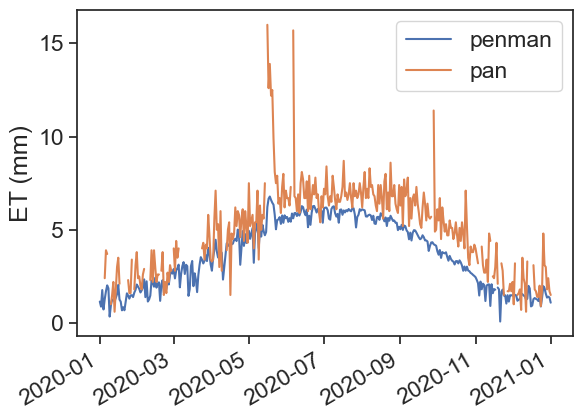

In [8]:
fig, ax = plt.subplots(1)
ax.plot(penm, label="penman")
ax.plot(df_pan["Daily evaporation type A (mm)"], label="pan")
ax.legend()
plt.gcf().autofmt_xdate()  # makes slanted dates
ax.set_ylabel("ET (mm)");

## Thornthwaite


$$
E = 16\left[ \frac{10\,T^\text{monthly mean}}{I} \right]^a,
$$

where

$$
I = \sum_{i=1}^{12} \left[ \frac{T_i^\text{monthly mean}}{5} \right]^{1.514},
$$

and

$$
\begin{split}
a &= 6.75\times 10^{-7}I^3 \\
   &- 7.71\times 10^{-5}I^2 \\
   &+ 1.792\times 10^{-2}I \\
   &+ 0.49239 \nonumber
\end{split}
$$

 - $E$ is the monthly potential ET (mm)
 - $T_\text{monthly mean}$ is the mean monthly temperature in °C
 - $I$ is a heat index
 - $a$ is a location-dependent coefficient

From df, make a new dataframe, df_th, that stores monthly temperatures means. Use `resample` function.

In [9]:
# monthly data
df_th = (df['Temperature (°C)'].resample('MS')  # MS assigns mean to first day in the month
                               .mean()
                               .to_frame()
        )
        
# we now add 14 days to the index, so that all monthly data is in the middle of the month
# not really necessary, makes plot look better
df_th.index = df_th.index + pd.DateOffset(days=14)
df_th

,Temperature (°C)
timestamp,
2020-01-15,12.484812
2020-02-15,14.044349
2020-03-15,16.371381
2020-04-15,18.476339
2020-05-15,23.177769
2020-06-15,24.666423
2020-07-15,27.380466
2020-08-15,28.099328
2020-09-15,28.421644


Calculate $I$, then $a$, and finally $E_p$. Add $E_p$ as a new column in df_th.

In [10]:
# Preparing "I" for the Thornthwaite equation
I = np.sum(
             (
               df_th['Temperature (°C)'] / 5
             ) ** (1.514)
          )

# Preparing "a" for the Thornthwaite equation
a = (+6.75e-7 * I**3 
     -7.71e-5 * I**2
     +1.792e-2 * I
     + 0.49239)

# The final Thornthwaite model for monthly potential ET (mm)
df_th['Ep (mm/month)'] = 16*(
                               (
                                  10 * df_th['Temperature (°C)'] / I
                               ) ** a
                            )
df_th

,Temperature (°C),Ep (mm/month)
timestamp,,
2020-01-15,12.484812,20.695370
2020-02-15,14.044349,27.765987
2020-03-15,16.371381,40.716009
2020-04-15,18.476339,55.071668
2020-05-15,23.177769,96.997621
2020-06-15,24.666423,113.308714
2020-07-15,27.380466,147.047919
2020-08-15,28.099328,156.877841
2020-09-15,28.421644,161.409587


Text(0, 0.5, 'ET (mm/day)')

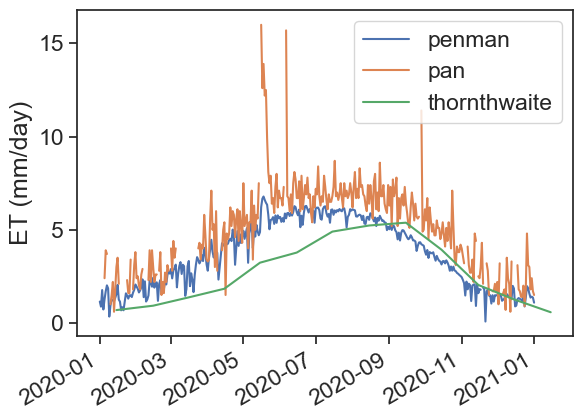

In [11]:
fig, ax = plt.subplots(1)
ax.plot(penm, label="penman")
ax.plot(df_pan["Daily evaporation type A (mm)"], label="pan")
ax.plot(df_th['Ep (mm/month)']/30, label="thornthwaite")

ax.legend()
plt.gcf().autofmt_xdate()  # makes slated dates
ax.set_ylabel("ET (mm/day)")

## Data from NOAA

Let's download data from a different repository. More specifically, we will retrieve sub-hourly data from the U.S. Climate Reference Network. We can see all the sites in [this map](https://www.ncei.noaa.gov/access/crn/). Besides the sub-hourly data, we can find [other datasets](https://www.ncei.noaa.gov/access/crn/qcdatasets.html) (monthly, daily, etc).

As an example, we will choose the statin in [Austin, Texas](https://www.ncei.noaa.gov/access/crn/sensors.htm?stationId=1386). In order to download, we will access the data from the FTP client using the python package `noaa_ftp`.

The `dir` command list everything in the folder:

In [12]:
noaa_dir = NOAA("ftp.ncdc.noaa.gov", 'pub/data/uscrn/products/subhourly01').dir()

drwxrwsr-x   2 ftp      ftp          8192 Oct  7  2020 2006
drwxrwsr-x   2 ftp      ftp          8192 Nov 10  2021 2007
drwxrwsr-x   2 ftp      ftp          8192 Dec  1  2020 2008
drwxrwsr-x   2 ftp      ftp         12288 May 25  2021 2009
drwxrwsr-x   2 ftp      ftp         12288 Nov 10  2021 2010
drwxrwsr-x   2 ftp      ftp         12288 Nov 12  2021 2011
drwxrwsr-x   2 ftp      ftp         12288 Nov 12  2021 2012
drwxrwsr-x   2 ftp      ftp         12288 Nov 15  2021 2013
drwxrwsr-x   2 ftp      ftp         12288 Nov 15  2021 2014
drwxrwsr-x   2 ftp      ftp         12288 Nov 12  2021 2015
drwxrwsr-x   2 ftp      ftp         12288 Nov 12  2021 2016
drwxrwsr-x   2 ftp      ftp         12288 Nov 15  2021 2017
drwxrwsr-x   2 ftp      ftp         12288 Nov 12  2021 2018
drwxrwsr-x   2 ftp      ftp         12288 Nov 24  2021 2019
drwxrwsr-x   2 ftp      ftp         12288 Nov 30  2021 2020
drwxrwsr-x   2 ftp      ftp         12288 Jan 29  2022 2021
drwxrwsr-x   2 ftp      ftp         1228

It's worth clicking [here](https://www.ncei.noaa.gov/pub/data/uscrn/products/subhourly01/) to see this directory with your own eyes. You can use your browser to explore this. Click on `readme.txt` and, well, read it.

Let's download two files:

* sub-hourly data for the year 2022 for Austin, TX.
* the `HEADERS.txt` contains the names of the columns in the csv.

Type the following lines:

```python
noaa = NOAA("ftp.ncdc.noaa.gov", 'pub/data/uscrn/products/subhourly01').download('HEADERS.txt')
noaa = NOAA("ftp.ncdc.noaa.gov", 'pub/data/uscrn/products/subhourly01/2022').download('CRNS0101-05-2022-TX_Austin_33_NW.txt')
```

If for some reason you can't download directly from NOAA, click here to get the files:

* <a href="HEADERS.txt" download>HEADERS.txt</a>
* <a href="CRNS0101-05-2022-TX_Austin_33_NW.txt" download>CRNS0101-05-2022-TX_Austin_33_NW.txt</a>

In [18]:
# Read column names from another file
column_names = pd.read_csv('HEADERS.txt',
                           header=None,
                           sep='\s+',
                           )
# Read CSV file using column names from another file
df = pd.read_csv("CRNS0101-05-2022-TX_Austin_33_NW.txt",  # file to read
                 sep='\s+',  # use (any number of) white spaces as delimiter between columns
                 names=column_names.iloc[1],  # column names from row i=1 of "column_names"
                 na_values=[-99, -9999, -99999],  # substitute these values by NaN
                 )
# make integer column LST_DATE as string
df['LST_DATE'] = df['LST_DATE'].astype(str)#.apply(lambda x: f'{x:0>4}')
# make integer column LST_DATE as string
# pad numbers with 0 from the left, such that 15 becomes 0015
df['LST_TIME'] = df['LST_TIME'].apply(lambda x: f'{x:0>4}')
# combine both DATE and TIME 
df['datetime'] = pd.to_datetime(df['LST_DATE'] + df['LST_TIME'], format='%Y%m%d%H%M')
df = df.set_index('datetime')
df

,WBANNO,UTC_DATE,UTC_TIME,LST_DATE,LST_TIME,CRX_VN,LONGITUDE,LATITUDE,AIR_TEMPERATURE,PRECIPITATION,...,ST_TYPE,ST_FLAG,RELATIVE_HUMIDITY,RH_FLAG,SOIL_MOISTURE_5,SOIL_TEMPERATURE_5,WETNESS,WET_FLAG,WIND_1_5,WIND_FLAG
datetime,,,,,,,,,,,,,,,,,,,,,
2021-12-31 18:05:00,23907,20220101,5,20211231,1805,2.623,-98.08,30.62,23.3,0.0,...,C,0,66.0,0,NaN,NaN,964.0,0,1.48,0
2021-12-31 18:10:00,23907,20220101,10,20211231,1810,2.623,-98.08,30.62,23.3,0.0,...,C,0,66.0,0,NaN,NaN,964.0,0,1.48,0
2021-12-31 18:15:00,23907,20220101,15,20211231,1815,2.623,-98.08,30.62,23.2,0.0,...,C,0,66.0,0,NaN,NaN,964.0,0,1.01,0
2021-12-31 18:20:00,23907,20220101,20,20211231,1820,2.623,-98.08,30.62,23.1,0.0,...,C,0,66.0,0,NaN,NaN,964.0,0,0.51,0
2021-12-31 18:25:00,23907,20220101,25,20211231,1825,2.623,-98.08,30.62,22.7,0.0,...,C,0,68.0,0,NaN,NaN,964.0,0,0.67,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 17:40:00,23907,20221231,2340,20221231,1740,2.623,-98.08,30.62,20.8,0.0,...,C,0,37.0,0,NaN,NaN,964.0,0,2.92,0
2022-12-31 17:45:00,23907,20221231,2345,20221231,1745,2.623,-98.08,30.62,20.7,0.0,...,C,0,37.0,0,NaN,NaN,963.0,0,2.94,0
2022-12-31 17:50:00,23907,20221231,2350,20221231,1750,2.623,-98.08,30.62,20.6,0.0,...,C,0,37.0,0,NaN,NaN,962.0,0,3.61,0


The provided data is not the same as what is provided by the IMS.

* Now we don't have air pressure values, so we need to provide elevation.
* We do have $R_n$ (net radiation), so there is no need to provide latitude.

**Attention!** According to the headers file, net radiation provided by NOAA is in W m$^{-2}$, but pyet requires it to be MJ m$^{-2}$ d$^{-1}$. We need to agreggate the downloaded data into daily radiation.

Data comes in 5-minute intervals, so if we have a value $x$ W m$^{-2}$ over a 5-minute interval, the total amount of energy is:

$$
x \frac{W}{m^{-2}}\times 5\, min = x \frac{J}{m^{-2}\cdot s}\times 5\cdot 60\, s = x\cdot 5 \cdot 60 \frac{J}{m^{-2}}
$$

Let's call $X=\sum_{day}x$. Then, summing all energy in 1 day:

$$
\sum_{day}x \cdot 5 \cdot 60 \frac{J}{m^{-2}\cdot day} = \sum_{day}x \cdot 5 \cdot 60\cdot 10^{-6} \frac{MJ}{m^{-2}\cdot day}
$$



Make a new dataframe with daily means for temperature, relative humidity and wind speed.

In [14]:
df_TX = df[['AIR_TEMPERATURE',
            'RELATIVE_HUMIDITY',
            'WIND_1_5']].resample('D').mean()
df_TX

,AIR_TEMPERATURE,RELATIVE_HUMIDITY,WIND_1_5
datetime,,,
2021-12-31,21.721127,79.985915,2.113662
2022-01-01,18.336806,65.833333,2.586840
2022-01-02,-0.222222,46.187500,3.849757
2022-01-03,4.592708,36.927083,0.892778
2022-01-04,9.964583,41.996528,2.428924
...,...,...,...
2022-12-27,6.534375,50.871528,1.881597
2022-12-28,14.418056,65.090278,3.289167
2022-12-29,16.878125,72.934028,2.068750


In [15]:
X = df['SOLAR_RADIATION'].resample('D').sum()
df_TX['SOLAR_RADIATION'] = X * 5 * 60 * 1e-6
df_TX

,AIR_TEMPERATURE,RELATIVE_HUMIDITY,WIND_1_5,SOLAR_RADIATION
datetime,,,,
2021-12-31,21.721127,79.985915,2.113662,0.0000
2022-01-01,18.336806,65.833333,2.586840,7.2870
2022-01-02,-0.222222,46.187500,3.849757,14.2536
2022-01-03,4.592708,36.927083,0.892778,14.4309
2022-01-04,9.964583,41.996528,2.428924,14.2056
...,...,...,...,...
2022-12-27,6.534375,50.871528,1.881597,11.5200
2022-12-28,14.418056,65.090278,3.289167,10.9917
2022-12-29,16.878125,72.934028,2.068750,5.9829


Let's use PYET to calculate the potential ET. This is the time to go to the library's GitHub page and read the functions: <https://github.com/pyet-org/pyet/tree/master>

In [21]:
elevation = 358
penm2 = pyet.combination.penman(tmean=df_TX["AIR_TEMPERATURE"],
                                wind=df_TX["WIND_1_5"],
                                elevation=elevation,
                                rh=df_TX["RELATIVE_HUMIDITY"],
                                rn=df_TX["SOLAR_RADIATION"],
                                )

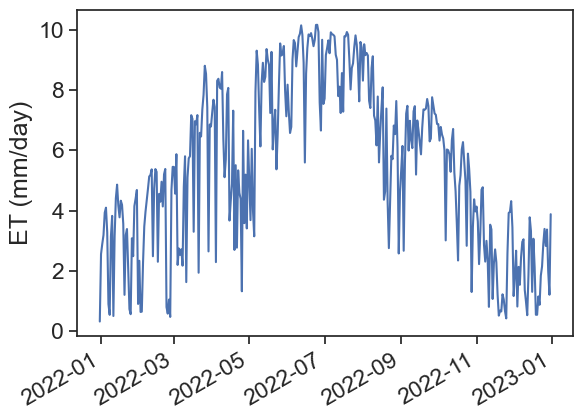

In [22]:
fig, ax = plt.subplots(1)
ax.plot(penm2, label="penman")
plt.gcf().autofmt_xdate()  # makes slanted dates
ax.set_ylabel("ET (mm/day)");

Does this make sense? How can we know?

What happens if we download data from a station, and we're missing Solar Radiation? What to do? The library PYET can infer solar ratiation given the station latitude and the number of daylight hours in the day.


In [23]:
lat = 30.62  # degrees
lat = pyet.utils.deg_to_rad(lat)
df_TX['daylight_hours'] = pyet.meteo_utils.daylight_hours(tmean.index, lat)
penm3 = pyet.combination.penman(tmean=df_TX["AIR_TEMPERATURE"],
                                wind=df_TX["WIND_1_5"],
                                elevation=elevation,
                                rh=df_TX["RELATIVE_HUMIDITY"],
                                lat=lat,
                                n=df_TX['daylight_hours'],
                                )

Text(0, 0.5, 'ET (mm/day)')

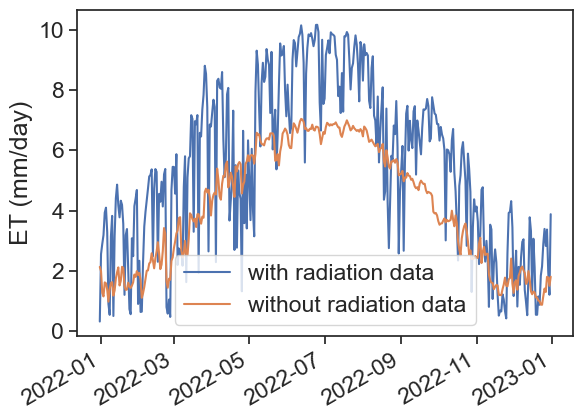

In [24]:
fig, ax = plt.subplots(1)
ax.plot(penm2, label="with radiation data")
ax.plot(penm3, label="without radiation data")
ax.legend()
plt.gcf().autofmt_xdate()  # makes slated dates
ax.set_ylabel("ET (mm/day)")